# **<center>Problema Arbitraje Financiero</center>**

**Teoría**

`Formulación (basada en aristas)`


Construimos un grafo dirigido en el que cada nodo corresponde a un activo, y cada arista dirigida se pondera con el tasa de conversión correspondiente. Un tipo de conversión $c_{ij}$ significa que si se tiene una unidad del bien i, se puede convertir en  $c_{ij}$ unidades del bien j sin coste adicional. En general, el tipo de conversión del bien i al bien j es diferente del tipo de conversión del bien j al bien i tipo de conversión del activo j al activo i (es decir,  $c_{ij} \neq c_{ji}$, en general). Se supone que los costes de transacción están incluidos en el por lo que existe un coste de transacción relativo (por unidad) y ningún coste de transacción fijo (por transacción). El problema de optimización problema de optimización que queremos resolver es encontrar el ciclo más rentable en este gráfico. Para encontrar la oportunidad de arbitraje más rentable, buscamos maximizar el producto de las tasas de conversión en un ciclo. Definamos una variable de decisión binaria $x_{ij}$ que sea igual a uno si la arista correspondiente está incluida en el ciclo elegido, y cero en caso contrario. La formulación basada en nodos se expresa matematicamente como la busqueda del maximo de la siguiente función acompañada de sus correspondientes restricciones:


$$max \sum_{(i,j) \in E} x_{ij}log(c_{ij})$$

Donde la función objetivo poesee varias restricciones:

- $\forall i \in V$ debe cumplirse: 

$$\sum_{j,(i,j) \in E} x_{ij} = \sum_{j,(j,i) \in E} x_{ji} $$

- $\forall i \in V$ debe cumplirse: 

$$\sum_{j,(i,j) \in E} x_{ij} \leq 1$$

**Librerias**

In [21]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from neal import SimulatedAnnealingSampler
from qubovert import boolean_var

from dwave.system import LeapHybridSampler

import dwave.inspector
from dwave.system import DWaveSampler, LazyFixedEmbeddingComposite

**Garfo tipo**

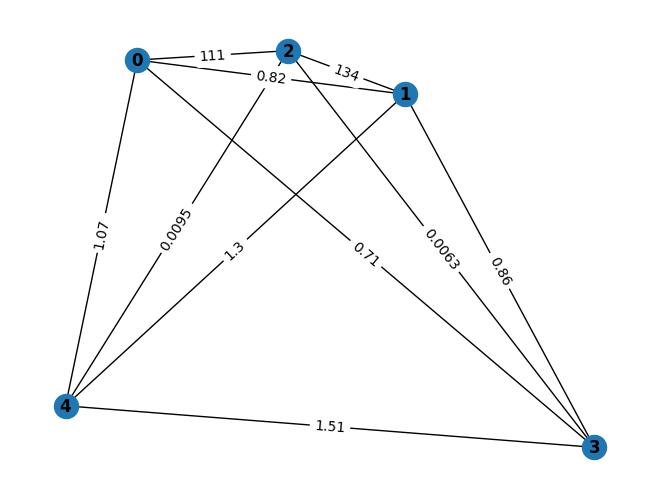

In [14]:
# Definir las monedas

monedas = ['USD', 'EUR', 'JPY', 'GBP', 'AUD']
monedas = [0,1,2,3,4]

# Definir las tasas de conversión

tasas_conversion = [[1, 0.82, 111, 0.71, 1.07],
                    [1.22, 1, 134, 0.86, 1.30],
                    [0.009, 0.007, 1, 0.0063, 0.0095],
                    [1.40, 1.15, 155, 1, 1.51],
                    [0.94, 0.78, 106, 0.66, 1]]

# Crear un grafo

G = nx.Graph()

# Agregar nodos

G.add_nodes_from(monedas)

# Agregar aristas

for i in range(len(monedas)):
    for j in range(i+1, len(monedas)):
        G.add_edge(monedas[i], monedas[j], weight=tasas_conversion[i][j])

# Dibujar el grafo

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [22]:
# Obtenemos el numero de monedas

N = G.number_of_nodes()

# Creamos todas las variables binarias de nuestro problema Aribtraje para un tamañano dado por N

x = {}
n_monedas = N 

# Guardamos una lista de duplas en el que almacenamos solo las parejas de indices (u, v) que permite la topologia del grafo

permitted_variables = []

for u in range(n_monedas):
    for v in range(n_monedas):
        if G.has_edge(u, v):
           permitted_variables.append((u, v))

# Creamos las variables binarias que estan permitidas por el grafo 

for u, v  in permitted_variables:
    x[(u, v)] = boolean_var('x{}_{}'.format(u, v))


# Construimos la función objetivo donde G[u][v]['weight'] representa la tasa de conversion C_uv

model = sum(x[(u, v)]*np.log(G[u][v]['weight']) for u, v in permitted_variables)

# Fijamos el coeficiente de Lagrange

lamda = 400

# Añadimos las restricciones asociadas al problema del Arbitraje 
# Restricción 1

for i, j in permitted_variables:
    model.add_constraint_eq_zero(sum(x[(i, j)]) -1, lam=lamda )